In [1]:
import pandas as pd
import src.utils as utils
import os
from faker import Faker

from sklearn.model_selection import train_test_split

# Load config file

In [2]:
CONFIG_DATA = utils.config_load()
CONFIG_DATA

{'raw_dataset_path': 'data/raw',
 'data_set_path': 'data/output/data.pkl',
 'input_set_path': 'data/output/input.pkl',
 'output_set_path': 'data/output/output.pkl',
 'input_columns_path': 'data/output/input_columns.pkl',
 'train_set_path': ['data/output/X_train.pkl', 'data/output/y_train.pkl'],
 'valid_set_path': ['data/output/X_valid.pkl', 'data/output/y_valid.pkl'],
 'test_set_path': ['data/output/X_test.pkl', 'data/output/y_test.pkl'],
 'output_column': 'category_encoded',
 'seed': 42,
 'test_size': 0.2,
 'standardizer_path': 'data/output/standardizer.pkl',
 'preprocessor_path': 'data/output/preprocessor.pkl',
 'train_clean_path': ['data/output/X_train_clean.pkl',
  'data/output/y_train_clean.pkl'],
 'valid_clean_path': ['data/output/X_valid_clean.pkl',
  'data/output/y_valid_clean.pkl'],
 'test_clean_path': ['data/output/X_test_clean.pkl',
  'data/output/y_test_clean.pkl'],
 'list_of_model_path': 'log/list_of_model.pkl',
 'list_of_param_path': 'log/list_of_param.pkl',
 'list_of_tun

## Load Data

In [3]:
CONFIG_DATA['train_set_path'][0]

'data/output/X_train.pkl'

In [4]:
X_train = utils.pickle_load(CONFIG_DATA['train_set_path'][0])
y_train = utils.pickle_load(CONFIG_DATA['train_set_path'][1])

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (355, 8)
y_train shape: (355,)


In [5]:
data = pd.concat((X_train, y_train), axis=1)
data.head()

,customer_id,product_id,purchase_date,category,price,ratings,page_views,time_spent,category_encoded
321,1,86,2023-05-10,Electronics,92,2.8,39,250,2
355,9,53,2023-05-31,Home & Kitchen,113,4.9,45,281,3
115,6,68,2023-06-11,Electronics,596,1.1,18,172,2
258,7,6,2023-11-24,Clothing,842,1.6,28,126,1
404,16,56,2023-10-18,Clothing,675,1.5,49,228,1


# EDA

cek data types

In [6]:
data.dtypes

customer_id           int64
product_id            int64
purchase_date        object
category             object
price                 int64
ratings             float64
page_views            int64
time_spent            int64
category_encoded      int64
dtype: object

In [7]:
# cek missing values
data.isna().sum()

customer_id         0
product_id          0
purchase_date       0
category            0
price               0
ratings             0
page_views          0
time_spent          0
category_encoded    0
dtype: int64

In [8]:
data.isna().sum().sum()

0

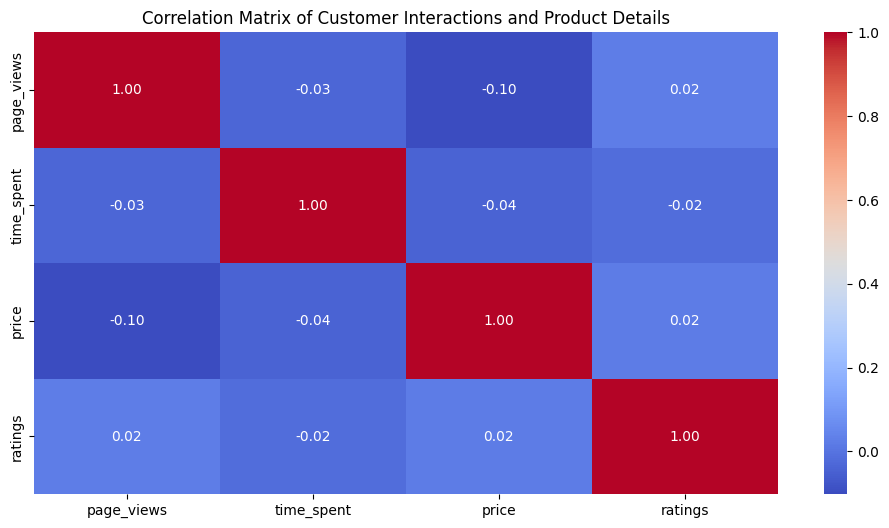

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Correlation matrix customer_interactions dan product_details
correlation_matrix = data[['page_views', 'time_spent', 'price', 'ratings']].corr()

# show heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Customer Interactions and Product Details')
plt.show()


- page_views dan time_spent: Ada korelasi positif, yang menunjukkan bahwa user yang melihat lebih banyak halaman cenderung menghabiskan lebih banyak waktu di situs. Hal ini menunjukkan bahwa konten yang menarik berpotensi meningkatkan waktu penelusuran.

- page_views dan price: Terdapat korelasi yang negatiif, yang menunjukkan bahwa variabel tersebut sangat lemah atau bahkan tidak ada hubungan linear yang signifikan di antara keduanya. Peningkatan atau penurunan jumlah page_views tidak berdampak secara konsisten pada price, dan sebaliknya.

- time_spent dan price: time_spent yang dihabiskan di situs menunjukkan korelasi yang lemah dengan harga produk yang dibeli.

- ratings: page_views dan spent_time korelasinya sangat lemah dengan ratings, yang mungkin menunjukkan bahwa keputusan user untuk melihat halaman atau spent_time tidak terlalu dipengaruhi oleh peringkat produk.

note: korelasi mendekati 1 menunjukkan korelasi positif. Korelasi mendekati -1 menunjukkan tidak adanya hubungan linear antara dua variabel.

### Cek produk kategori yang populer dan pola pembeliannya

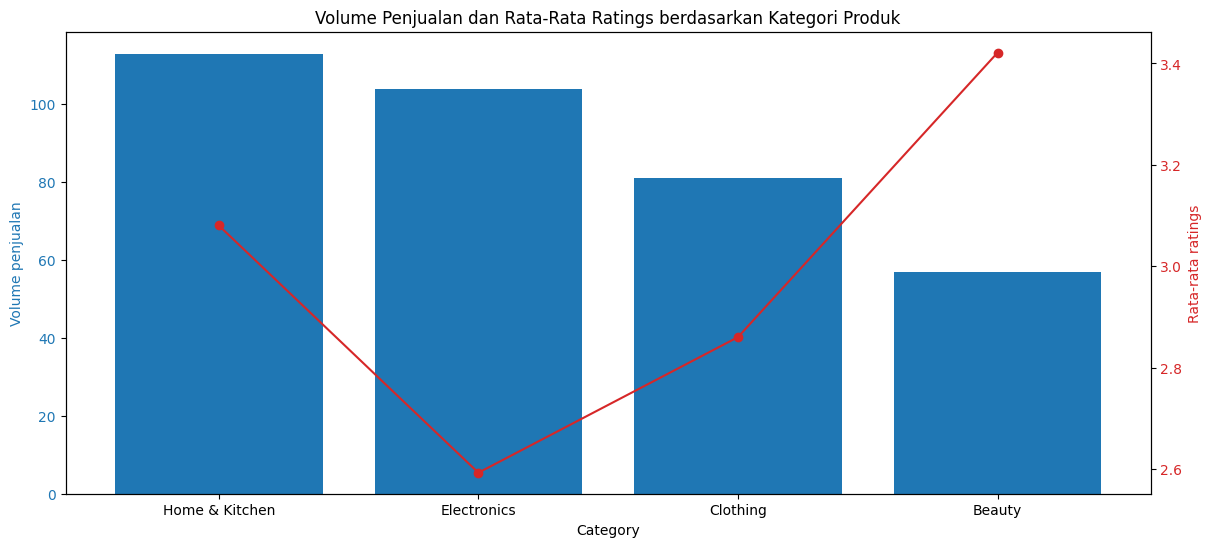

In [10]:
# Grouping data
category_analysis = data.groupby('category').agg(
    Sales_Volume=('product_id', 'count'),
    Average_Price=('price', 'mean'),
    Average_Ratings=('ratings', 'mean')
).sort_values(by='Sales_Volume', ascending=False)


fig, ax1 = plt.subplots(figsize=(14, 6))

# plot sales volume
color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Volume penjualan', color=color)
ax1.bar(category_analysis.index, category_analysis['Sales_Volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# plot twin axis untuk rata2 ratings
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rata-rata ratings', color=color)
ax2.plot(category_analysis.index, category_analysis['Average_Ratings'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Volume Penjualan dan Rata-Rata Ratings berdasarkan Kategori Produk')
plt.show()


In [11]:
data['ratings'].value_counts()

ratings
1.5    31
2.1    28
2.8    27
3.8    23
2.2    19
1.1    18
4.9    18
3.5    17
4.7    16
3.6    16
3.2    14
1.6    12
2.3    12
5.0    12
1.8    11
4.6    10
2.9    10
3.1     9
3.3     9
4.2     9
4.4     7
2.6     6
2.7     5
1.4     4
2.0     4
1.0     3
1.9     2
4.5     2
3.0     1
Name: count, dtype: int64

Karna ini pakai data dummy jadi seperti ada anomali, dimana kategori yang punya volume penjualan terbanyak malah memiliki rata2 rating paling kecil.
Pada real case nya rata2 rating mempengaruhi keputusan pembelian

**Insight**
1. Category performance: Kategori dengan penjualan lebih tinggi dan rating yang lebih baik mungkin diprioritaskan untuk keputusan dilakukan promosi. Sebaliknya, kategori dengan penjualan dan peringkat lebih rendah mungkin memerlukan penyesuaian pemasaran atau peningkatan kualitas produk.

2. Strategi pemasaran: Memahami kategori mana yang punya kinerja baik dalam hal penjualan dan kepuasan pelanggan busa membantu menyesuaikan strategi pemasaran.

### Tren Analysis

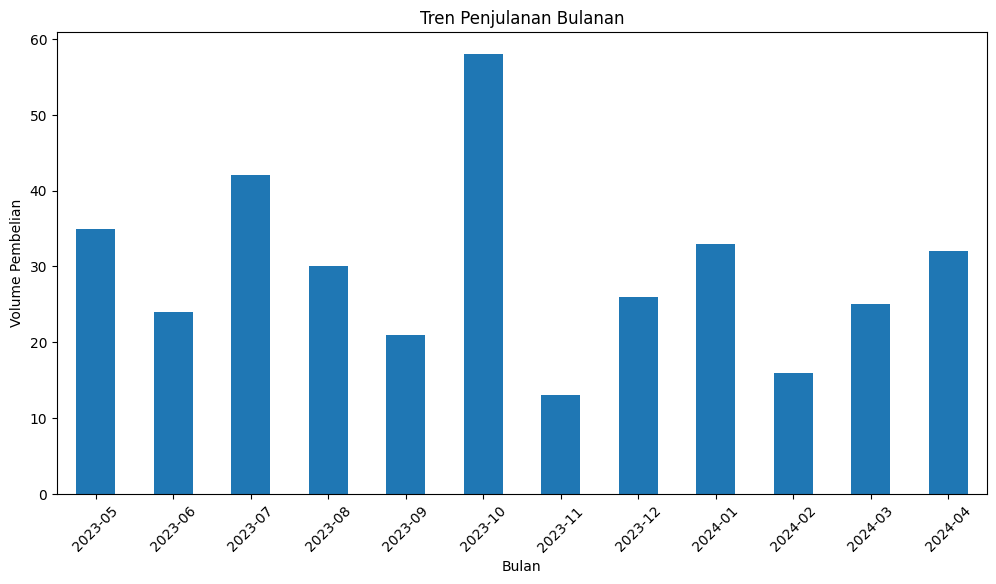

In [12]:
# convert 'purchase_date' jadi datetime dan untuk ekstrak bulan dan tahun
data['purchase_date'] = pd.to_datetime(data['purchase_date'])
data['year_month'] = data['purchase_date'].dt.to_period('M')

# Grouping berdasarkan bulan untuk menghitung penmbelian
monthly_sales = data.groupby('year_month').size()

# Plotting 
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar')
plt.title('Tren Penjulanan Bulanan')
plt.xlabel('Bulan')
plt.ylabel('Volume Pembelian')
plt.xticks(rotation=45)
plt.show()


selama 1 tahun, penujalan paling rendah ada di bulan maret 2024, dan paling tinggi di april 2024

### Product Performance analysis

In [13]:
# Asumsi kategori teratas berdasarkan data volume penjualan sebelumnya, mpakai 3 kategori teratas untuk analisis yang lebih detail
# identifikasi 3 kategori teratas
top_categories = category_analysis.index[:3]

# filter data untuk dari ketegori terats
top_category_data = data[data['category'].isin(top_categories)]

# Grouping data berdasarkan produk dalam kategori teratas untuk menganalisis volume penjualan, harga rata2, dan rata2 rating
product_performance = top_category_data.groupby(['category', 'product_id']).agg(
    Sales_Volume=('product_id', 'count'),
    Average_Price=('price', 'mean'),
    Average_Ratings=('ratings', 'mean')
).sort_values(by=['category', 'Sales_Volume'], ascending=False)

product_performance.reset_index().head(10)  # tampilkan top 10

,category,product_id,Sales_Volume,Average_Price,Average_Ratings
0,Home & Kitchen,62,14,997.0,3.2
1,Home & Kitchen,7,10,574.0,2.9
2,Home & Kitchen,92,10,313.0,1.5
3,Home & Kitchen,53,8,113.0,4.9
4,Home & Kitchen,99,8,383.0,5.0
5,Home & Kitchen,25,7,435.0,4.2
6,Home & Kitchen,103,7,401.0,1.5
7,Home & Kitchen,21,6,600.0,2.3
8,Home & Kitchen,91,6,214.0,4.6
9,Home & Kitchen,8,5,338.0,2.7


**INSIGHT**
1.  Penjualan Tertinggi dan Rating Tertinggi: Electronics 102 dan Electronics 103 menunjukkan kinerja yang baik berdasarkan volume penjualan yang tinggi dan tingkat kepuasan pelanggan.

2.   Sensitivitas Harga: Produk dengan harga lebih tinggi seperti Electronics 103 menunjukkan volume penjualan yang lebih rendah, menunjukkan sensitivitas harga dalam kategori ini.

3.   Rating: Clothing 105, ini penjualannya paling tinggi, tapi punya rating yang rendah, yang bisa menjadi area untuk perbaikan atau analisis feedback dari pelanggan.

**REKOMENDASI**
1. Strategi Penetapan Harga: Untuk barang dengan harga tinggi dengan penjualan lebih rendah, bisa dipertimbangkan untuk menyesuaikan harga atau meningkatkan kualitas dan fitur produk untuk meningkatkan rating dan kepuasan pelanggan.

2. Meningkatkan Kualitas Produk atau Layanan kepada Pelanggan: Untuk produk dengan rating yang rendah, teliti keluhan atau feedback dari pelanggan untuk meningkatkan kualitas produk.

3. Area Fokus Promosi: Produk yang berkinerja baik bisa dijadikan kampanye pemasaran untuk meningkatkan penjualan yang lebih masif.

## Data Processing
1. encode category:

In [14]:
def load_dataset(return_file=True):
    # Load train data
    X_train = utils.pickle_load(CONFIG_DATA['train_set_path'][0])
    y_train = utils.pickle_load(CONFIG_DATA['train_set_path'][1])

    # Load valid data
    X_valid = utils.pickle_load(CONFIG_DATA['valid_set_path'][0])
    y_valid = utils.pickle_load(CONFIG_DATA['valid_set_path'][1])

    # Load test data
    X_test = utils.pickle_load(CONFIG_DATA['test_set_path'][0])
    y_test = utils.pickle_load(CONFIG_DATA['test_set_path'][1])

    # Print 
    print("X_train shape :", X_train.shape)
    print("y_train shape :", y_train.shape)
    print("X_valid shape :", X_valid.shape)
    print("y_valid shape :", y_valid.shape)
    print("X_test shape  :", X_test.shape)
    print("y_test shape  :", y_test.shape)

    if return_file:
        return X_train, X_valid, X_test, y_train, y_valid, y_test

In [15]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_dataset()

X_train shape : (355, 8)
y_train shape : (355,)
X_valid shape : (89, 8)
y_valid shape : (89,)
X_test shape  : (111, 8)
y_test shape  : (111,)


## Preprocess train
scale the data

In [16]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import pickle


def fit_standardize(data, columns=['page_views', 'time_spent', 'price', 'ratings'], return_file=True):
    standardizer = RobustScaler()

    # Fit standardizer on the provided columns
    standardizer.fit(data[columns])
    
    # Dump standardizer
    utils.pickle_dump(standardizer, CONFIG_DATA['standardizer_path'])
    
    if return_file:
        return standardizer

In [17]:
# from sklearn.preprocessing import LabelEncoder

# # enocde categoru and Fit standardizer
# encoder = LabelEncoder()
# X_train['category_encoded'] = encoder.fit_transform(X_train['category'])
# X_test['category_encoded'] = encoder.fit_transform(X_test['category'])

standardizer = fit_standardize(data=X_train)

In [18]:
X_train

,customer_id,product_id,purchase_date,category,price,ratings,page_views,time_spent
321,1,86,2023-05-10,Electronics,92,2.8,39,250
355,9,53,2023-05-31,Home & Kitchen,113,4.9,45,281
115,6,68,2023-06-11,Electronics,596,1.1,18,172
258,7,6,2023-11-24,Clothing,842,1.6,28,126
404,16,56,2023-10-18,Clothing,675,1.5,49,228
...,...,...,...,...,...,...,...,...
322,1,86,2023-05-10,Electronics,92,2.8,39,250
242,2,64,2024-02-06,Electronics,500,4.7,23,103
216,19,68,2023-10-22,Electronics,596,1.1,43,167
214,19,68,2023-10-22,Electronics,596,1.1,13,162


In [19]:
X_train['customer_id'].value_counts()

customer_id
16    77
6     43
2     29
15    25
13    25
19    19
18    19
4     15
5     14
8     12
1     11
11    11
17    10
12     9
20     8
14     8
7      7
9      5
10     5
3      3
Name: count, dtype: int64

In [20]:
X_test

,customer_id,product_id,purchase_date,category,price,ratings,page_views,time_spent
231,11,3,2023-10-18,Beauty,367,2.2,6,152
374,6,53,2024-03-26,Home & Kitchen,113,4.9,3,230
55,16,76,2023-10-23,Clothing,183,2.1,9,206
381,15,65,2023-07-19,Home & Kitchen,669,1.5,13,299
70,13,62,2023-10-20,Home & Kitchen,997,3.2,27,174
...,...,...,...,...,...,...,...,...
11,19,62,2023-10-25,Home & Kitchen,997,3.2,13,162
281,9,8,2023-09-20,Home & Kitchen,338,2.7,45,281
22,7,73,2023-05-19,Electronics,613,2.0,28,126
375,4,25,2023-06-01,Home & Kitchen,435,4.2,43,272


In [21]:
X_train.describe()

,customer_id,product_id,price,ratings,page_views,time_spent
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,11.301408,57.256338,470.000000,2.942254,26.707042,160.636620
std,5.780532,30.034146,286.888647,1.172985,14.201290,72.728038
min,1.000000,2.000000,23.000000,1.000000,1.000000,30.000000
25%,6.000000,37.000000,213.000000,2.100000,15.000000,104.000000
50%,13.000000,62.000000,430.000000,2.800000,27.000000,160.000000
75%,16.000000,86.000000,675.000000,3.800000,39.000000,222.000000
max,20.000000,105.000000,997.000000,5.000000,49.000000,299.000000


In [22]:
X_test.describe()

,customer_id,product_id,price,ratings,page_views,time_spent
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,10.891892,62.513514,545.909910,2.884685,24.405405,169.558559
std,5.921227,30.748500,310.527192,1.056340,15.389712,74.501700
min,1.000000,2.000000,23.000000,1.100000,1.000000,37.000000
25%,6.000000,44.000000,313.000000,2.150000,12.000000,104.000000
50%,11.000000,63.000000,574.000000,2.800000,25.000000,167.000000
75%,16.000000,89.000000,823.000000,3.800000,38.500000,230.000000
max,20.000000,105.000000,997.000000,5.000000,49.000000,299.000000


In [23]:
y_train.value_counts(normalize=True)

category_encoded
3    0.318310
2    0.292958
1    0.228169
0    0.160563
Name: proportion, dtype: float64

do downsampling for majority product (only for training data)

In [24]:
from imblearn.under_sampling import RandomUnderSampler

In [25]:
def random_undersampler(X, y):
    """Function to under sample the majority data"""
    # Create resampling object
    ros = RandomUnderSampler(random_state = CONFIG_DATA['seed'])

    # Balancing the set data
    X_resample, y_resample = ros.fit_resample(X, y)

    # Print
    print('Distribution before resampling :')
    print(y.value_counts())
    print("")
    print('Distribution after resampling  :')
    print(y_resample.value_counts())

    return X_resample, y_resample

In [26]:
X_train_clean, y_train_clean = random_undersampler(X_train, y_train)

Distribution before resampling :
category_encoded
3    113
2    104
1     81
0     57
Name: count, dtype: int64

Distribution after resampling  :
category_encoded
0    57
1    57
2    57
3    57
Name: count, dtype: int64


for X train

In [27]:
# preprocess only for train data
def preprocess_data(type='train', return_file=True):
    """Function to preprocess train data"""
    # Load data
    X = utils.pickle_load(CONFIG_DATA[f'{type}_set_path'][0])
    y = utils.pickle_load(CONFIG_DATA[f'{type}_set_path'][1])
    
    # drop after ordinalencoded
    X.drop(columns=['purchase_date', 'category'], inplace=True) 
    y.drop(columns=['purchase_date', 'category',], inplace=True) 
    
    # Preprocess data
    X_clean = X
    y_clean = y

    # FOR TRAINING ONLY -> DO UNDERSAMPLING
    if type == 'train':
        X_clean, y_clean = random_undersampler(X, y)

    # Print shape
    print("X clean shape:", X_clean.shape)
    print("y clean shape:", y_clean.shape)

    # Dump file
    utils.pickle_dump(X_clean, CONFIG_DATA[f'{type}_clean_path'][0])
    utils.pickle_dump(y_clean, CONFIG_DATA[f'{type}_clean_path'][1])

    if return_file:
        return X_clean, y_clean    

In [28]:
# Transform X_train
X_train_clean, y_train_clean = preprocess_data(type = 'train')

Distribution before resampling :
category_encoded
3    113
2    104
1     81
0     57
Name: count, dtype: int64

Distribution after resampling  :
category_encoded
0    57
1    57
2    57
3    57
Name: count, dtype: int64
X clean shape: (228, 6)
y clean shape: (228,)


In [29]:
# Transform X_valid
X_valid_clean, y_valid_clean = preprocess_data(type = 'valid')

X clean shape: (89, 6)
y clean shape: (89,)


In [30]:
# Transform X_test
X_test_clean, y_test_clean = preprocess_data(type = 'test')

X clean shape: (111, 6)
y clean shape: (111,)


In [31]:
y_test_clean

231    0
374    3
55     1
381    3
70     3
      ..
11     3
281    3
22     2
375    3
477    2
Name: category_encoded, Length: 111, dtype: int64

In [32]:
X_train_clean.describe()

,customer_id,product_id,price,ratings,page_views,time_spent
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,11.315789,57.179825,494.609649,3.040789,25.942982,164.552632
std,5.822357,30.799453,287.676031,1.159201,13.954971,73.809087
min,1.000000,2.000000,23.000000,1.000000,1.000000,36.000000
25%,6.000000,37.000000,279.000000,2.100000,13.750000,111.000000
50%,13.000000,62.000000,471.000000,3.100000,26.000000,162.000000
75%,16.000000,86.000000,677.000000,3.800000,39.000000,225.000000
max,20.000000,105.000000,997.000000,5.000000,49.000000,299.000000


In [33]:
X_train_clean.columns.tolist()

['customer_id', 'product_id', 'price', 'ratings', 'page_views', 'time_spent']

In [37]:
y_train.tolist()

[2,
 3,
 2,
 1,
 1,
 2,
 2,
 3,
 1,
 3,
 2,
 2,
 3,
 1,
 2,
 1,
 3,
 2,
 3,
 0,
 0,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 3,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 1,
 0,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 0,
 1,
 3,
 2,
 3,
 3,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 3,
 0,
 0,
 2,
 1,
 2,
 3,
 3,
 2,
 2,
 3,
 3,
 0,
 2,
 3,
 1,
 1,
 1,
 3,
 0,
 3,
 1,
 2,
 0,
 3,
 1,
 1,
 3,
 0,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 3,
 2,
 2,
 1,
 2,
 2,
 1,
 3,
 2,
 3,
 3,
 1,
 0,
 0,
 2,
 0,
 3,
 3,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 1,
 2,
 3,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 3,
 1,
 1,
 2,
 3,
 3,
 3,
 1,
 2,
 3,
 1,
 3,
 1,
 2,
 3,
 2,
 3,
 3,
 1,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 3,
 3,
 0,
 1,
 3,
 3,
 1,
 2,
 2,
 3,
 3,
 0,
 1,
 1,
 1,
 0,
 1,
 3,
 0,
 2,
 1,
 3,
 3,
 3,
 2,
 3,
 2,
 1,
 3,
 3,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 3,
 2,
 3,
 3,
 3,
 0,
 2,
 3,
 3,
 2,
 0,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 3,
 0,
 3,
 3,
